In [4]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib as mpl
import numpy as np
import scipy.signal

#%matplotlib notebook
%matplotlib inline
mpl.rcParams['figure.figsize'] = (18, 6)


In [16]:
import os, glob, sys

files = glob.glob('csv/c*.csv')
# make sure we get a consistent order.
files.sort()
data = []
count = 0
for name in files: 
    try:
        print " reading  file " + name
        thisfile = np.loadtxt(name, skiprows=1, usecols=tuple((0,1,2,3,4)),delimiter=",")
        thisfile = scipy.signal.decimate(thisfile, 10, n=None, ftype='iir', axis=0, zero_phase=True)
        data.append(thisfile)
    except IOError as exc:
        if exc.errno != errno.EISDIR:
            pass
        else: # Do not fail if a directory is found, just ignore it.
            raise exc # Propagate other kinds of IOError.
    count += 1
    if count > 100:
        break
            
print "done"

 reading  file csv/c18-06-22-12_00.csv
 reading  file csv/c18-06-23-12_00.csv
 reading  file csv/c18-06-24-12_00.csv
 reading  file csv/c18-06-25-12_00.csv
 reading  file csv/c18-06-26-12_00.csv
 reading  file csv/c18-06-27-12_00.csv
 reading  file csv/c18-06-28-12_00.csv
 reading  file csv/c18-06-29-12_00.csv
 reading  file csv/c18-06-30-12_00.csv
 reading  file csv/c18-07-01-12_00.csv
 reading  file csv/c18-07-02-12_00.csv
 reading  file csv/c18-07-03-12_00.csv
 reading  file csv/c18-07-04-12_00.csv
 reading  file csv/c18-07-05-12_00.csv
 reading  file csv/c18-07-06-12_00.csv
 reading  file csv/c18-07-07-12_00.csv
 reading  file csv/c18-07-08-12_00.csv
 reading  file csv/c18-07-09-12_00.csv
 reading  file csv/c18-07-10-12_00.csv
 reading  file csv/c18-07-11-12_00.csv
 reading  file csv/c18-07-12-12_00.csv
 reading  file csv/c18-07-13-12_00.csv
 reading  file csv/c18-07-14-12_00.csv
 reading  file csv/c18-07-15-12_00.csv
 reading  file csv/c18-07-16-12_00.csv
 reading  file csv/c18-07

In [35]:
# massage data, correct for DST
day = 7420 # this many indexes in a day, roughly

hour = int(float(day)/24.) # chop this off to correct for dst
newd = []
d = data[0]
oldt = d[0,0]
dst = True
for i, d in enumerate(data[:]):
    if d.shape[0] > 7420:
        #print d.shape
        t = d[0,0]
        print(t -oldt)
        if (t - oldt) > 88000 and (t - oldt < 90000):
            dst = False
        if dst:
            # add in an hour to time 
            newd.append(d[hour:7420,:])
            print("DST")
        else:
            newd.append(d[0:7420-hour,:])
        oldt = t
            
        #del data
#print newd[0]
                    

0.0
DST
85409.067771
DST
85405.6211157
DST
85412.8921194
DST
85408.4225168
DST
85409.2091475
DST
85409.5844719
DST
85419.6310358
DST
85402.1681261
DST
85406.4225512
DST
170829.552721
DST
85400.9984751
DST
85424.3540182
DST
85403.0962458
DST
85411.810586
DST
85427.5406809
DST
85400.9799168
DST
85415.8684549
DST
85411.4500494
DST
85405.6106253
DST
85412.6871004
DST
85409.5669699
DST
85411.5408795
DST
85416.8501062
DST
85393.5852995
DST
85416.4228067
DST
85417.3116198
DST
85396.6138413
DST
85426.454915
DST
85407.5689402
DST
85404.0762167
DST
85430.4645319
DST
85397.2168226
DST
85400.3527863
DST
85423.3383722
DST
85405.2434759
DST
85413.1854372
DST
85407.178813
DST
85420.7763779
DST
85403.7604933
DST
85413.4753103
DST
85413.0282736
DST
85413.3390589
DST
85399.3103724
DST
85425.5676415
DST
85405.7929678
DST
85404.2149782
DST
85419.2551241
DST
85414.8797617
DST
85397.3127434
DST
85423.5744066
DST
85411.6600885
DST
170823.409622
DST
85400.3790312
DST
85418.5114872
DST
85409.7347574
DST
85409.

In [63]:
# Make linear array of decimated data
import scipy

decd = []
numdays = 100
for i, d in enumerate(newd[0:100]):
    q = d[:,1:4]
    decd.append(scipy.signal.decimate(q, 10, axis=0, ftype='iir', zero_phase=True))

decd = np.array(decd)     
ldays, lwidth, lcolors = decd.shape

print (ldays, lwidth, lcolors)

larr = decd.reshape(ldays*lwidth,lcolors)

# scale to zero-1, add epsilon so root of zero does not happen
print(np.max(larr))
print(np.min(larr))
larr = larr - np.min(larr) + np.finfo(float).eps


#larr = larr/np.max(larr) 
larr = larr/np.max(larr) 



# gamma correct 
larr = (larr)**(1/1.8)

print(np.max(larr))
print(np.min(larr))

print "done"
print larr.shape

arrlen = ldays*lwidth


(100, 712, 3)
64382.0082886
-0.106627362774
1.0
4.28589630395e-12
done
(71200, 3)


In [ ]:
# render frames
import imageio

def getcolor(cmap, frac):
    """ go fraction into cmap and return a color triple """
    l, w = cmap.shape
    assert(w ==3)
    i = int(l*frac)
    if i >= l:
        i = l-1
    if i < 0:
        i = 0
    return cmap[i,:]
    


width = 1080
height = 1080

#width = 200
#height = 200

out = np.zeros((height,width,3),dtype=float)

# this many frames in a day
framesperday = 120 # render at 30fps for smooth
# there are ldays of lwodth points in larray which is arrlen points long.
# we want lwidth/framesperday points to get n frames per day. Divide byarrlen to get
# scalefrac is the fraction (0-1) we should advance to get framesperday

scalefrac = float(lwidth)/(float(arrlen)*framesperday)


daysinframe = 2.5

# fraction of entire extent to use in one frame
# one day is lwidth points
ffrac = daysinframe*lwidth/float(arrlen)



offset = np.arange(0, 1.0 - ffrac, (1.0 - ffrac)*scalefrac)
#offset =[0.]
for i, off in enumerate(offset):
    print(off)
    minc = 999
    maxc = -999
    for w in range(width):
        for h in range(height):
        
            x = (w - width/2)/float(width) 
            y = (h - height/2)/float(height)
            r = np.sqrt(x*x + y*y)
            #th = np.arctan2(y,x)
            #out[h,w] = getcolor(daysg[1200],0.5*(1 + off -r))
            out[h,w] = getcolor(larr,off + (1. -r)*ffrac)

            #if np.min(out[h,w]) < minc:
            #    minc = np.min(out[h,w]) 
            if np.max(out[h,w]) > maxc:
                maxc = np.max(out[h,w]) 

        
    #print (minc, maxc)
    fname  = "long/f{:05d}.png".format(i)
    #fname  = "frames/f{:05d}.png".format(i)
    imageio.imwrite(fname, (255*out/maxc).astype(np.uint8))
    print "saved " + fname
    if i ==0 and False:
        fig = plt.figure(frameon=False, figsize = (12,12))
        plt.imshow(out)
        plt.axis('off')  
        fig.axes[0].get_xaxis().set_visible(False)
        fig.axes[0].get_yaxis().set_visible(False)
        #plt.savefig('advance{:03d}.png'.format(i),bbox_inches='tight', pad_inches=0)
        print "saved"
    # to convert to gif with imagemagick
    #$ /cygdrive/c/Program\ Files/ImageMagick-7.0.5-Q16/convert.exe   -delay 7 -loop 0 frame*.png ani.gif
   #ffmpeg -r 15 -f image2  -i frame%03d.png -vcodec libx264 -crf 25 -pix_fmt yuv420p  test.mp4

# imagemagic to get a gif
#!convert  -delay 7 -loop 0 frames/f*.png

#ffmpeg to get a mp4

#!ffmpeg -r 20 -f image2  -i long/f%05d.png -vcodec libx264 -crf 25 -pix_fmt yuv420p -y longout.mp4


0.0
saved long/f00000.png
8.125e-05
saved long/f00001.png
0.0001625
saved long/f00002.png
0.00024375
saved long/f00003.png
0.000325
saved long/f00004.png
0.00040625
saved long/f00005.png
0.0004875
saved long/f00006.png
0.00056875
saved long/f00007.png
0.00065
saved long/f00008.png
0.00073125
saved long/f00009.png
0.0008125
saved long/f00010.png
0.00089375
saved long/f00011.png
0.000975
saved long/f00012.png
0.00105625
saved long/f00013.png
0.0011375
saved long/f00014.png
0.00121875
saved long/f00015.png
0.0013
saved long/f00016.png
0.00138125
saved long/f00017.png
0.0014625
saved long/f00018.png
0.00154375
saved long/f00019.png
0.001625
saved long/f00020.png
0.00170625
saved long/f00021.png
0.0017875
saved long/f00022.png
0.00186875
saved long/f00023.png
0.00195
saved long/f00024.png
0.00203125
saved long/f00025.png
0.0021125
saved long/f00026.png
0.00219375
saved long/f00027.png
0.002275
saved long/f00028.png
0.00235625
saved long/f00029.png
0.0024375
saved long/f00030.png
0.00251875


saved long/f00256.png
0.02088125
saved long/f00257.png
0.0209625
saved long/f00258.png
0.02104375
saved long/f00259.png
0.021125
saved long/f00260.png
0.02120625
saved long/f00261.png
0.0212875
saved long/f00262.png
0.02136875
saved long/f00263.png
0.02145
saved long/f00264.png
0.02153125
saved long/f00265.png
0.0216125
saved long/f00266.png
0.02169375
saved long/f00267.png
0.021775
saved long/f00268.png
0.02185625
saved long/f00269.png
0.0219375
saved long/f00270.png
0.02201875
saved long/f00271.png
0.0221
saved long/f00272.png
0.02218125
saved long/f00273.png
0.0222625
saved long/f00274.png
0.02234375
saved long/f00275.png
0.022425
saved long/f00276.png
0.02250625
saved long/f00277.png
0.0225875
saved long/f00278.png
0.02266875
saved long/f00279.png
0.02275
saved long/f00280.png
0.02283125
saved long/f00281.png
0.0229125
saved long/f00282.png
0.02299375
saved long/f00283.png
0.023075
saved long/f00284.png
0.02315625
saved long/f00285.png
0.0232375
saved long/f00286.png
0.02331875
sav

saved long/f00512.png
0.04168125
saved long/f00513.png
0.0417625
saved long/f00514.png
0.04184375
saved long/f00515.png
0.041925
saved long/f00516.png
0.04200625
saved long/f00517.png
0.0420875
saved long/f00518.png
0.04216875
saved long/f00519.png
0.04225
saved long/f00520.png
0.04233125
saved long/f00521.png
0.0424125
saved long/f00522.png
0.04249375
saved long/f00523.png
0.042575
saved long/f00524.png
0.04265625
saved long/f00525.png
0.0427375
saved long/f00526.png
0.04281875
saved long/f00527.png
0.0429
saved long/f00528.png
0.04298125
saved long/f00529.png
0.0430625
saved long/f00530.png
0.04314375
saved long/f00531.png
0.043225
saved long/f00532.png
0.04330625
saved long/f00533.png
0.0433875
saved long/f00534.png
0.04346875
saved long/f00535.png
0.04355
saved long/f00536.png
0.04363125
saved long/f00537.png
0.0437125
saved long/f00538.png
0.04379375
saved long/f00539.png
0.043875
saved long/f00540.png
0.04395625
saved long/f00541.png
0.0440375
saved long/f00542.png
0.04411875
sav

saved long/f00768.png
0.06248125
saved long/f00769.png
0.0625625
saved long/f00770.png
0.06264375
saved long/f00771.png
0.062725
saved long/f00772.png
0.06280625
saved long/f00773.png
0.0628875
saved long/f00774.png
0.06296875
saved long/f00775.png
0.06305
saved long/f00776.png
0.06313125
saved long/f00777.png
0.0632125
saved long/f00778.png
0.06329375
saved long/f00779.png
0.063375
saved long/f00780.png
0.06345625
saved long/f00781.png
0.0635375
saved long/f00782.png
0.06361875
saved long/f00783.png
0.0637
saved long/f00784.png
0.06378125
saved long/f00785.png
0.0638625
saved long/f00786.png
0.06394375
saved long/f00787.png
0.064025
saved long/f00788.png
0.06410625
saved long/f00789.png
0.0641875
saved long/f00790.png
0.06426875
saved long/f00791.png
0.06435
saved long/f00792.png
0.06443125
saved long/f00793.png
0.0645125
saved long/f00794.png
0.06459375
saved long/f00795.png
0.064675
saved long/f00796.png
0.06475625
saved long/f00797.png
0.0648375
saved long/f00798.png
0.06491875
sav

saved long/f01024.png
0.08328125
saved long/f01025.png
0.0833625
saved long/f01026.png
0.08344375
saved long/f01027.png
0.083525
saved long/f01028.png
0.08360625
saved long/f01029.png
0.0836875
saved long/f01030.png
0.08376875
saved long/f01031.png
0.08385
saved long/f01032.png
0.08393125
saved long/f01033.png
0.0840125
saved long/f01034.png
0.08409375
saved long/f01035.png
0.084175
saved long/f01036.png
0.08425625
saved long/f01037.png
0.0843375
saved long/f01038.png
0.08441875
saved long/f01039.png
0.0845
saved long/f01040.png
0.08458125
saved long/f01041.png
0.0846625
saved long/f01042.png
0.08474375
saved long/f01043.png
0.084825
saved long/f01044.png
0.08490625
saved long/f01045.png
0.0849875
saved long/f01046.png
0.08506875
saved long/f01047.png
0.08515
saved long/f01048.png
0.08523125
saved long/f01049.png
0.0853125
saved long/f01050.png
0.08539375
saved long/f01051.png
0.085475
saved long/f01052.png
0.08555625
saved long/f01053.png
0.0856375
saved long/f01054.png
0.08571875
sav

saved long/f01280.png
0.10408125
saved long/f01281.png
0.1041625
saved long/f01282.png
0.10424375
saved long/f01283.png
0.104325
saved long/f01284.png
0.10440625
saved long/f01285.png
0.1044875
saved long/f01286.png
0.10456875
saved long/f01287.png
0.10465
saved long/f01288.png
0.10473125
saved long/f01289.png
0.1048125
saved long/f01290.png
0.10489375
saved long/f01291.png
0.104975
saved long/f01292.png
0.10505625
saved long/f01293.png
0.1051375
saved long/f01294.png
0.10521875
saved long/f01295.png
0.1053
saved long/f01296.png
0.10538125
saved long/f01297.png
0.1054625
saved long/f01298.png
0.10554375
saved long/f01299.png
0.105625
saved long/f01300.png
0.10570625
saved long/f01301.png
0.1057875
saved long/f01302.png
0.10586875
saved long/f01303.png
0.10595
saved long/f01304.png
0.10603125
saved long/f01305.png
0.1061125
saved long/f01306.png
0.10619375
saved long/f01307.png
0.106275
saved long/f01308.png
0.10635625
saved long/f01309.png
0.1064375
saved long/f01310.png
0.10651875
sav

saved long/f01536.png
0.12488125
saved long/f01537.png
0.1249625
saved long/f01538.png
0.12504375
saved long/f01539.png
0.125125
saved long/f01540.png
0.12520625
saved long/f01541.png
0.1252875
saved long/f01542.png
0.12536875
saved long/f01543.png
0.12545
saved long/f01544.png
0.12553125
saved long/f01545.png
0.1256125
saved long/f01546.png
0.12569375
saved long/f01547.png
0.125775
saved long/f01548.png
0.12585625
saved long/f01549.png
0.1259375
saved long/f01550.png
0.12601875
saved long/f01551.png
0.1261
saved long/f01552.png
0.12618125
saved long/f01553.png
0.1262625
saved long/f01554.png
0.12634375
saved long/f01555.png
0.126425
saved long/f01556.png
0.12650625
saved long/f01557.png
0.1265875
saved long/f01558.png
0.12666875
saved long/f01559.png
0.12675
saved long/f01560.png
0.12683125
saved long/f01561.png
0.1269125
saved long/f01562.png
0.12699375
saved long/f01563.png
0.127075
saved long/f01564.png
0.12715625
saved long/f01565.png
0.1272375
saved long/f01566.png
0.12731875
sav

saved long/f01792.png
0.14568125
saved long/f01793.png
0.1457625
saved long/f01794.png
0.14584375
saved long/f01795.png
0.145925
saved long/f01796.png
0.14600625
saved long/f01797.png
0.1460875
saved long/f01798.png
0.14616875
saved long/f01799.png
0.14625
saved long/f01800.png
0.14633125
saved long/f01801.png
0.1464125
saved long/f01802.png
0.14649375
saved long/f01803.png
0.146575
saved long/f01804.png
0.14665625
saved long/f01805.png
0.1467375
saved long/f01806.png
0.14681875
saved long/f01807.png
0.1469
saved long/f01808.png
0.14698125
saved long/f01809.png
0.1470625
saved long/f01810.png
0.14714375
saved long/f01811.png
0.147225
saved long/f01812.png
0.14730625
saved long/f01813.png
0.1473875
saved long/f01814.png
0.14746875
saved long/f01815.png
0.14755
saved long/f01816.png
0.14763125
saved long/f01817.png
0.1477125
saved long/f01818.png
0.14779375
saved long/f01819.png
0.147875
saved long/f01820.png
0.14795625
saved long/f01821.png
0.1480375
saved long/f01822.png
0.14811875
sav

saved long/f02048.png
0.16648125
saved long/f02049.png
0.1665625
saved long/f02050.png
0.16664375
saved long/f02051.png
0.166725
saved long/f02052.png
0.16680625
saved long/f02053.png
0.1668875
saved long/f02054.png
0.16696875
saved long/f02055.png
0.16705
saved long/f02056.png
0.16713125
saved long/f02057.png
0.1672125
saved long/f02058.png
0.16729375
saved long/f02059.png
0.167375
saved long/f02060.png
0.16745625
saved long/f02061.png
0.1675375
saved long/f02062.png
0.16761875
saved long/f02063.png
0.1677
saved long/f02064.png
0.16778125
saved long/f02065.png
0.1678625
saved long/f02066.png
0.16794375
saved long/f02067.png
0.168025
saved long/f02068.png
0.16810625
saved long/f02069.png
0.1681875
saved long/f02070.png
0.16826875
saved long/f02071.png
0.16835
saved long/f02072.png
0.16843125
saved long/f02073.png
0.1685125
saved long/f02074.png
0.16859375
saved long/f02075.png
0.168675
saved long/f02076.png
0.16875625
saved long/f02077.png
0.1688375
saved long/f02078.png
0.16891875
sav

saved long/f02304.png
0.18728125
saved long/f02305.png
0.1873625
saved long/f02306.png
0.18744375
saved long/f02307.png
0.187525
saved long/f02308.png
0.18760625
saved long/f02309.png
0.1876875
saved long/f02310.png
0.18776875
saved long/f02311.png
0.18785
saved long/f02312.png
0.18793125
saved long/f02313.png
0.1880125
saved long/f02314.png
0.18809375
saved long/f02315.png
0.188175
saved long/f02316.png
0.18825625
saved long/f02317.png
0.1883375
saved long/f02318.png
0.18841875
saved long/f02319.png
0.1885
saved long/f02320.png
0.18858125
saved long/f02321.png
0.1886625
saved long/f02322.png
0.18874375
saved long/f02323.png
0.188825
saved long/f02324.png
0.18890625
saved long/f02325.png
0.1889875
saved long/f02326.png
0.18906875
saved long/f02327.png
0.18915
saved long/f02328.png
0.18923125
saved long/f02329.png
0.1893125
saved long/f02330.png
0.18939375
saved long/f02331.png
0.189475
saved long/f02332.png
0.18955625
saved long/f02333.png
0.1896375
saved long/f02334.png
0.18971875
sav

saved long/f02560.png
0.20808125
saved long/f02561.png
0.2081625
saved long/f02562.png
0.20824375
saved long/f02563.png
0.208325
saved long/f02564.png
0.20840625
saved long/f02565.png
0.2084875
saved long/f02566.png
0.20856875
saved long/f02567.png
0.20865
saved long/f02568.png
0.20873125
saved long/f02569.png
0.2088125
saved long/f02570.png
0.20889375
saved long/f02571.png
0.208975
saved long/f02572.png
0.20905625
saved long/f02573.png
0.2091375
saved long/f02574.png
0.20921875
saved long/f02575.png
0.2093
saved long/f02576.png
0.20938125
saved long/f02577.png
0.2094625
saved long/f02578.png
0.20954375
saved long/f02579.png
0.209625
saved long/f02580.png
0.20970625
saved long/f02581.png
0.2097875
saved long/f02582.png
0.20986875
saved long/f02583.png
0.20995
saved long/f02584.png
0.21003125
saved long/f02585.png
0.2101125
saved long/f02586.png
0.21019375
saved long/f02587.png
0.210275
saved long/f02588.png
0.21035625
saved long/f02589.png
0.2104375
saved long/f02590.png
0.21051875
sav

saved long/f02816.png
0.22888125
saved long/f02817.png
0.2289625
saved long/f02818.png
0.22904375
saved long/f02819.png
0.229125
saved long/f02820.png
0.22920625
saved long/f02821.png
0.2292875
saved long/f02822.png
0.22936875
saved long/f02823.png
0.22945
saved long/f02824.png
0.22953125
saved long/f02825.png
0.2296125
saved long/f02826.png
0.22969375
saved long/f02827.png
0.229775
saved long/f02828.png
0.22985625
saved long/f02829.png
0.2299375
saved long/f02830.png
0.23001875
saved long/f02831.png
0.2301
saved long/f02832.png
0.23018125
saved long/f02833.png
0.2302625
saved long/f02834.png
0.23034375
saved long/f02835.png
0.230425
saved long/f02836.png
0.23050625
saved long/f02837.png
0.2305875
saved long/f02838.png
0.23066875
saved long/f02839.png
0.23075
saved long/f02840.png
0.23083125
saved long/f02841.png
0.2309125
saved long/f02842.png
0.23099375
saved long/f02843.png
0.231075
saved long/f02844.png
0.23115625
saved long/f02845.png
0.2312375
saved long/f02846.png
0.23131875
sav

saved long/f03072.png
0.24968125
saved long/f03073.png
0.2497625
saved long/f03074.png
0.24984375
saved long/f03075.png
0.249925
saved long/f03076.png
0.25000625
saved long/f03077.png
0.2500875
saved long/f03078.png
0.25016875
saved long/f03079.png
0.25025
saved long/f03080.png
0.25033125
saved long/f03081.png
0.2504125
saved long/f03082.png
0.25049375
saved long/f03083.png
0.250575
saved long/f03084.png
0.25065625
saved long/f03085.png
0.2507375
saved long/f03086.png
0.25081875
saved long/f03087.png
0.2509
saved long/f03088.png
0.25098125
saved long/f03089.png
0.2510625
saved long/f03090.png
0.25114375
saved long/f03091.png
0.251225
saved long/f03092.png
0.25130625
saved long/f03093.png
0.2513875
saved long/f03094.png
0.25146875
saved long/f03095.png
0.25155
saved long/f03096.png
0.25163125
saved long/f03097.png
0.2517125
saved long/f03098.png
0.25179375
saved long/f03099.png
0.251875
saved long/f03100.png
0.25195625
saved long/f03101.png
0.2520375
saved long/f03102.png
0.25211875
sav

saved long/f03328.png
0.27048125
saved long/f03329.png
0.2705625
saved long/f03330.png
0.27064375
saved long/f03331.png
0.270725
saved long/f03332.png
0.27080625
saved long/f03333.png
0.2708875
saved long/f03334.png
0.27096875
saved long/f03335.png
0.27105
saved long/f03336.png
0.27113125
saved long/f03337.png
0.2712125
saved long/f03338.png
0.27129375
saved long/f03339.png
0.271375
saved long/f03340.png
0.27145625
saved long/f03341.png
0.2715375
saved long/f03342.png
0.27161875
saved long/f03343.png
0.2717
saved long/f03344.png
0.27178125
saved long/f03345.png
0.2718625
saved long/f03346.png
0.27194375
saved long/f03347.png
0.272025
saved long/f03348.png
0.27210625
saved long/f03349.png
0.2721875
saved long/f03350.png
0.27226875
saved long/f03351.png
0.27235
saved long/f03352.png
0.27243125
saved long/f03353.png
0.2725125
saved long/f03354.png
0.27259375
saved long/f03355.png
0.272675
saved long/f03356.png
0.27275625
saved long/f03357.png
0.2728375
saved long/f03358.png
0.27291875
sav

saved long/f03584.png
0.29128125
saved long/f03585.png
0.2913625
saved long/f03586.png
0.29144375
saved long/f03587.png
0.291525
saved long/f03588.png
0.29160625
saved long/f03589.png
0.2916875
saved long/f03590.png
0.29176875
saved long/f03591.png
0.29185
saved long/f03592.png
0.29193125
saved long/f03593.png
0.2920125
saved long/f03594.png
0.29209375
saved long/f03595.png
0.292175
saved long/f03596.png
0.29225625
saved long/f03597.png
0.2923375
saved long/f03598.png
0.29241875
saved long/f03599.png
0.2925
saved long/f03600.png
0.29258125
saved long/f03601.png
0.2926625
saved long/f03602.png
0.29274375
saved long/f03603.png
0.292825
saved long/f03604.png
0.29290625
saved long/f03605.png
0.2929875
saved long/f03606.png
0.29306875
saved long/f03607.png
0.29315
saved long/f03608.png
0.29323125
saved long/f03609.png
0.2933125
saved long/f03610.png
0.29339375
saved long/f03611.png
0.293475
saved long/f03612.png
0.29355625
saved long/f03613.png
0.2936375
saved long/f03614.png
0.29371875
sav

saved long/f03840.png
0.31208125
saved long/f03841.png
0.3121625
saved long/f03842.png
0.31224375
saved long/f03843.png
0.312325
saved long/f03844.png
0.31240625
saved long/f03845.png
0.3124875
saved long/f03846.png
0.31256875
saved long/f03847.png
0.31265
saved long/f03848.png
0.31273125
saved long/f03849.png
0.3128125
saved long/f03850.png
0.31289375
saved long/f03851.png
0.312975
saved long/f03852.png
0.31305625
saved long/f03853.png
0.3131375
saved long/f03854.png
0.31321875
saved long/f03855.png
0.3133
saved long/f03856.png
0.31338125
saved long/f03857.png
0.3134625
saved long/f03858.png
0.31354375
saved long/f03859.png
0.313625
saved long/f03860.png
0.31370625
saved long/f03861.png
0.3137875
saved long/f03862.png
0.31386875
saved long/f03863.png
0.31395
saved long/f03864.png
0.31403125
saved long/f03865.png
0.3141125
saved long/f03866.png
0.31419375
saved long/f03867.png
0.314275
saved long/f03868.png
0.31435625
saved long/f03869.png
0.3144375
saved long/f03870.png
0.31451875
sav

saved long/f04096.png
0.33288125
saved long/f04097.png
0.3329625
saved long/f04098.png
0.33304375
saved long/f04099.png
0.333125
saved long/f04100.png
0.33320625
saved long/f04101.png
0.3332875
saved long/f04102.png
0.33336875
saved long/f04103.png
0.33345
saved long/f04104.png
0.33353125
saved long/f04105.png
0.3336125
saved long/f04106.png
0.33369375
saved long/f04107.png
0.333775
saved long/f04108.png
0.33385625
saved long/f04109.png
0.3339375
saved long/f04110.png
0.33401875
saved long/f04111.png
0.3341
saved long/f04112.png
0.33418125
saved long/f04113.png
0.3342625
saved long/f04114.png
0.33434375
saved long/f04115.png
0.334425
saved long/f04116.png
0.33450625
saved long/f04117.png
0.3345875
saved long/f04118.png
0.33466875
saved long/f04119.png
0.33475
saved long/f04120.png
0.33483125
saved long/f04121.png
0.3349125
saved long/f04122.png
0.33499375
saved long/f04123.png
0.335075
saved long/f04124.png
0.33515625
saved long/f04125.png
0.3352375
saved long/f04126.png
0.33531875
sav

saved long/f04352.png
0.35368125
saved long/f04353.png
0.3537625
saved long/f04354.png
0.35384375
saved long/f04355.png
0.353925
saved long/f04356.png
0.35400625
saved long/f04357.png
0.3540875
saved long/f04358.png
0.35416875
saved long/f04359.png
0.35425
saved long/f04360.png
0.35433125
saved long/f04361.png
0.3544125
saved long/f04362.png
0.35449375
saved long/f04363.png
0.354575
saved long/f04364.png
0.35465625
saved long/f04365.png
0.3547375
saved long/f04366.png
0.35481875
saved long/f04367.png
0.3549
saved long/f04368.png
0.35498125
saved long/f04369.png
0.3550625
saved long/f04370.png
0.35514375
saved long/f04371.png
0.355225
saved long/f04372.png
0.35530625
saved long/f04373.png
0.3553875
saved long/f04374.png
0.35546875
saved long/f04375.png
0.35555
saved long/f04376.png
0.35563125
saved long/f04377.png
0.3557125
saved long/f04378.png
0.35579375
saved long/f04379.png
0.355875
saved long/f04380.png
0.35595625
saved long/f04381.png
0.3560375
saved long/f04382.png
0.35611875
sav

saved long/f04608.png
0.37448125
saved long/f04609.png
0.3745625
saved long/f04610.png
0.37464375
saved long/f04611.png
0.374725
saved long/f04612.png
0.37480625
saved long/f04613.png
0.3748875
saved long/f04614.png
0.37496875
saved long/f04615.png
0.37505
saved long/f04616.png
0.37513125
saved long/f04617.png
0.3752125
saved long/f04618.png
0.37529375
saved long/f04619.png
0.375375
saved long/f04620.png
0.37545625
saved long/f04621.png
0.3755375
saved long/f04622.png
0.37561875
saved long/f04623.png
0.3757
saved long/f04624.png
0.37578125
saved long/f04625.png
0.3758625
saved long/f04626.png
0.37594375
saved long/f04627.png
0.376025
saved long/f04628.png
0.37610625
saved long/f04629.png
0.3761875
saved long/f04630.png
0.37626875
saved long/f04631.png
0.37635
saved long/f04632.png
0.37643125
saved long/f04633.png
0.3765125
saved long/f04634.png
0.37659375
saved long/f04635.png
0.376675
saved long/f04636.png
0.37675625
saved long/f04637.png
0.3768375
saved long/f04638.png
0.37691875
sav

saved long/f04864.png
0.39528125
saved long/f04865.png
0.3953625
saved long/f04866.png
0.39544375
saved long/f04867.png
0.395525
saved long/f04868.png
0.39560625
saved long/f04869.png
0.3956875
saved long/f04870.png
0.39576875
saved long/f04871.png
0.39585
saved long/f04872.png
0.39593125
saved long/f04873.png
0.3960125
saved long/f04874.png
0.39609375
saved long/f04875.png
0.396175
saved long/f04876.png
0.39625625
saved long/f04877.png
0.3963375
saved long/f04878.png
0.39641875
saved long/f04879.png
0.3965
saved long/f04880.png
0.39658125
saved long/f04881.png
0.3966625
saved long/f04882.png
0.39674375
saved long/f04883.png
0.396825
saved long/f04884.png
0.39690625
saved long/f04885.png
0.3969875
saved long/f04886.png
0.39706875
saved long/f04887.png
0.39715
saved long/f04888.png
0.39723125
saved long/f04889.png
0.3973125
saved long/f04890.png
0.39739375
saved long/f04891.png
0.397475
saved long/f04892.png
0.39755625
saved long/f04893.png
0.3976375
saved long/f04894.png
0.39771875
sav

saved long/f05120.png
0.41608125
saved long/f05121.png
0.4161625
saved long/f05122.png
0.41624375
saved long/f05123.png
0.416325
saved long/f05124.png
0.41640625
saved long/f05125.png
0.4164875
saved long/f05126.png
0.41656875
saved long/f05127.png
0.41665
saved long/f05128.png
0.41673125
saved long/f05129.png
0.4168125
saved long/f05130.png
0.41689375
saved long/f05131.png
0.416975
saved long/f05132.png
0.41705625
saved long/f05133.png
0.4171375
saved long/f05134.png
0.41721875
saved long/f05135.png
0.4173
saved long/f05136.png
0.41738125
saved long/f05137.png
0.4174625
saved long/f05138.png
0.41754375
saved long/f05139.png
0.417625
saved long/f05140.png
0.41770625
saved long/f05141.png
0.4177875
saved long/f05142.png
0.41786875
saved long/f05143.png
0.41795
saved long/f05144.png
0.41803125
saved long/f05145.png
0.4181125
saved long/f05146.png
0.41819375
saved long/f05147.png
0.418275
saved long/f05148.png
0.41835625
saved long/f05149.png
0.4184375
saved long/f05150.png
0.41851875
sav

saved long/f05376.png
0.43688125
saved long/f05377.png
0.4369625
saved long/f05378.png
0.43704375
saved long/f05379.png
0.437125
saved long/f05380.png
0.43720625
saved long/f05381.png
0.4372875
saved long/f05382.png
0.43736875
saved long/f05383.png
0.43745
saved long/f05384.png
0.43753125
saved long/f05385.png
0.4376125
saved long/f05386.png
0.43769375
saved long/f05387.png
0.437775
saved long/f05388.png
0.43785625
saved long/f05389.png
0.4379375
saved long/f05390.png
0.43801875
saved long/f05391.png
0.4381
saved long/f05392.png
0.43818125
saved long/f05393.png
0.4382625
saved long/f05394.png
0.43834375
saved long/f05395.png
0.438425
saved long/f05396.png
0.43850625
saved long/f05397.png
0.4385875
saved long/f05398.png
0.43866875
saved long/f05399.png
0.43875
saved long/f05400.png
0.43883125
saved long/f05401.png
0.4389125
saved long/f05402.png
0.43899375
saved long/f05403.png
0.439075
saved long/f05404.png
0.43915625
saved long/f05405.png
0.4392375
saved long/f05406.png
0.43931875
sav

saved long/f05632.png
0.45768125
saved long/f05633.png
0.4577625
saved long/f05634.png
0.45784375
saved long/f05635.png
0.457925
saved long/f05636.png
0.45800625
saved long/f05637.png
0.4580875
saved long/f05638.png
0.45816875
saved long/f05639.png
0.45825
saved long/f05640.png
0.45833125
saved long/f05641.png
0.4584125
saved long/f05642.png
0.45849375
saved long/f05643.png
0.458575
saved long/f05644.png
0.45865625
saved long/f05645.png
0.4587375
saved long/f05646.png
0.45881875
saved long/f05647.png
0.4589
saved long/f05648.png
0.45898125
saved long/f05649.png
0.4590625
saved long/f05650.png
0.45914375
saved long/f05651.png
0.459225
saved long/f05652.png
0.45930625
saved long/f05653.png
0.4593875
saved long/f05654.png
0.45946875
saved long/f05655.png
0.45955
saved long/f05656.png
0.45963125
saved long/f05657.png
0.4597125
saved long/f05658.png
0.45979375
saved long/f05659.png
0.459875
saved long/f05660.png
0.45995625
saved long/f05661.png
0.4600375
saved long/f05662.png
0.46011875
sav

saved long/f05888.png
0.47848125
saved long/f05889.png
0.4785625
saved long/f05890.png
0.47864375
saved long/f05891.png
0.478725
saved long/f05892.png
0.47880625
saved long/f05893.png
0.4788875
saved long/f05894.png
0.47896875
saved long/f05895.png
0.47905
saved long/f05896.png
0.47913125
saved long/f05897.png
0.4792125
saved long/f05898.png
0.47929375
saved long/f05899.png
0.479375
saved long/f05900.png
0.47945625
saved long/f05901.png
0.4795375
saved long/f05902.png
0.47961875
saved long/f05903.png
0.4797
saved long/f05904.png
0.47978125
saved long/f05905.png
0.4798625
saved long/f05906.png
0.47994375
saved long/f05907.png
0.480025
saved long/f05908.png
0.48010625
saved long/f05909.png
0.4801875
saved long/f05910.png
0.48026875
saved long/f05911.png
0.48035
saved long/f05912.png
0.48043125
saved long/f05913.png
0.4805125
saved long/f05914.png
0.48059375
saved long/f05915.png
0.480675
saved long/f05916.png
0.48075625
saved long/f05917.png
0.4808375
saved long/f05918.png
0.48091875
sav

saved long/f06144.png
0.49928125
saved long/f06145.png
0.4993625
saved long/f06146.png
0.49944375
saved long/f06147.png
0.499525
saved long/f06148.png
0.49960625
saved long/f06149.png
0.4996875
saved long/f06150.png
0.49976875
saved long/f06151.png
0.49985
saved long/f06152.png
0.49993125
saved long/f06153.png
0.5000125
saved long/f06154.png
0.50009375
saved long/f06155.png
0.500175
saved long/f06156.png
0.50025625
saved long/f06157.png
0.5003375
saved long/f06158.png
0.50041875
saved long/f06159.png
0.5005
saved long/f06160.png
0.50058125
saved long/f06161.png
0.5006625
saved long/f06162.png
0.50074375
saved long/f06163.png
0.500825
saved long/f06164.png
0.50090625
saved long/f06165.png
0.5009875
saved long/f06166.png
0.50106875
saved long/f06167.png
0.50115
saved long/f06168.png
0.50123125
saved long/f06169.png
0.5013125
saved long/f06170.png
0.50139375
saved long/f06171.png
0.501475
saved long/f06172.png
0.50155625
saved long/f06173.png
0.5016375
saved long/f06174.png
0.50171875
sav

saved long/f06400.png
0.52008125
saved long/f06401.png
0.5201625
saved long/f06402.png
0.52024375
saved long/f06403.png
0.520325
saved long/f06404.png
0.52040625
saved long/f06405.png
0.5204875
saved long/f06406.png
0.52056875
saved long/f06407.png
0.52065
saved long/f06408.png
0.52073125
saved long/f06409.png
0.5208125
saved long/f06410.png
0.52089375
saved long/f06411.png
0.520975
saved long/f06412.png
0.52105625
saved long/f06413.png
0.5211375
saved long/f06414.png
0.52121875
saved long/f06415.png
0.5213
saved long/f06416.png
0.52138125
saved long/f06417.png
0.5214625
saved long/f06418.png
0.52154375
saved long/f06419.png
0.521625
saved long/f06420.png
0.52170625
saved long/f06421.png
0.5217875
saved long/f06422.png
0.52186875
saved long/f06423.png
0.52195
saved long/f06424.png
0.52203125
saved long/f06425.png
0.5221125
saved long/f06426.png
0.52219375
saved long/f06427.png
0.522275
saved long/f06428.png
0.52235625
saved long/f06429.png
0.5224375
saved long/f06430.png
0.52251875
sav

saved long/f06656.png
0.54088125
saved long/f06657.png
0.5409625
saved long/f06658.png
0.54104375
saved long/f06659.png
0.541125
saved long/f06660.png
0.54120625
saved long/f06661.png
0.5412875
saved long/f06662.png
0.54136875
saved long/f06663.png
0.54145
saved long/f06664.png
0.54153125
saved long/f06665.png
0.5416125
saved long/f06666.png
0.54169375
saved long/f06667.png
0.541775
saved long/f06668.png
0.54185625
saved long/f06669.png
0.5419375
saved long/f06670.png
0.54201875
saved long/f06671.png
0.5421
saved long/f06672.png
0.54218125
saved long/f06673.png
0.5422625
saved long/f06674.png
0.54234375
saved long/f06675.png
0.542425
saved long/f06676.png
0.54250625
saved long/f06677.png
0.5425875
saved long/f06678.png
0.54266875
saved long/f06679.png
0.54275
saved long/f06680.png
0.54283125
saved long/f06681.png
0.5429125
saved long/f06682.png
0.54299375
saved long/f06683.png
0.543075
saved long/f06684.png
0.54315625
saved long/f06685.png
0.5432375
saved long/f06686.png
0.54331875
sav

saved long/f06912.png
0.56168125
saved long/f06913.png
0.5617625
saved long/f06914.png
0.56184375
saved long/f06915.png
0.561925
saved long/f06916.png
0.56200625
saved long/f06917.png
0.5620875
saved long/f06918.png
0.56216875
saved long/f06919.png
0.56225
saved long/f06920.png
0.56233125
saved long/f06921.png
0.5624125
saved long/f06922.png
0.56249375
saved long/f06923.png
0.562575
saved long/f06924.png
0.56265625
saved long/f06925.png
0.5627375
saved long/f06926.png
0.56281875
saved long/f06927.png
0.5629
saved long/f06928.png
0.56298125
saved long/f06929.png
0.5630625
saved long/f06930.png
0.56314375
saved long/f06931.png
0.563225
saved long/f06932.png
0.56330625
saved long/f06933.png
0.5633875
saved long/f06934.png
0.56346875
saved long/f06935.png
0.56355
saved long/f06936.png
0.56363125
saved long/f06937.png
0.5637125
saved long/f06938.png
0.56379375
saved long/f06939.png
0.563875
saved long/f06940.png
0.56395625
saved long/f06941.png
0.5640375
saved long/f06942.png
0.56411875
sav

saved long/f07168.png
0.58248125
saved long/f07169.png
0.5825625
saved long/f07170.png
0.58264375
saved long/f07171.png
0.582725
saved long/f07172.png
0.58280625
saved long/f07173.png
0.5828875
saved long/f07174.png
0.58296875
saved long/f07175.png
0.58305
saved long/f07176.png
0.58313125
saved long/f07177.png
0.5832125
saved long/f07178.png
0.58329375
saved long/f07179.png
0.583375
saved long/f07180.png
0.58345625
saved long/f07181.png
0.5835375
saved long/f07182.png
0.58361875
saved long/f07183.png
0.5837
saved long/f07184.png
0.58378125
saved long/f07185.png
0.5838625
saved long/f07186.png
0.58394375
saved long/f07187.png
0.584025
saved long/f07188.png
0.58410625
saved long/f07189.png
0.5841875
saved long/f07190.png
0.58426875
saved long/f07191.png
0.58435
saved long/f07192.png
0.58443125
saved long/f07193.png
0.5845125
saved long/f07194.png
0.58459375
saved long/f07195.png
0.584675
saved long/f07196.png
0.58475625
saved long/f07197.png
0.5848375
saved long/f07198.png
0.58491875
sav

saved long/f07424.png
0.60328125
saved long/f07425.png
0.6033625
saved long/f07426.png
0.60344375
saved long/f07427.png
0.603525
saved long/f07428.png
0.60360625
saved long/f07429.png
0.6036875
saved long/f07430.png
0.60376875
saved long/f07431.png
0.60385
saved long/f07432.png
0.60393125
saved long/f07433.png
0.6040125
saved long/f07434.png
0.60409375
saved long/f07435.png
0.604175
saved long/f07436.png
0.60425625
saved long/f07437.png
0.6043375
saved long/f07438.png
0.60441875
saved long/f07439.png
0.6045
saved long/f07440.png
0.60458125
saved long/f07441.png
0.6046625
saved long/f07442.png
0.60474375
saved long/f07443.png
0.604825
saved long/f07444.png
0.60490625
saved long/f07445.png
0.6049875
saved long/f07446.png
0.60506875
saved long/f07447.png
0.60515
saved long/f07448.png
0.60523125
saved long/f07449.png
0.6053125
saved long/f07450.png
0.60539375
saved long/f07451.png
0.605475
saved long/f07452.png
0.60555625
saved long/f07453.png
0.6056375
saved long/f07454.png
0.60571875
sav

saved long/f07680.png
0.62408125
saved long/f07681.png
0.6241625
saved long/f07682.png
0.62424375
saved long/f07683.png
0.624325
saved long/f07684.png
0.62440625
saved long/f07685.png
0.6244875
saved long/f07686.png
0.62456875
saved long/f07687.png
0.62465
saved long/f07688.png
0.62473125
saved long/f07689.png
0.6248125
saved long/f07690.png
0.62489375
saved long/f07691.png
0.624975
saved long/f07692.png
0.62505625
saved long/f07693.png
0.6251375
saved long/f07694.png
0.62521875
saved long/f07695.png
0.6253
saved long/f07696.png
0.62538125
saved long/f07697.png
0.6254625
saved long/f07698.png
0.62554375
saved long/f07699.png
0.625625
saved long/f07700.png
0.62570625
saved long/f07701.png
0.6257875
saved long/f07702.png
0.62586875
saved long/f07703.png
0.62595
saved long/f07704.png
0.62603125
saved long/f07705.png
0.6261125
saved long/f07706.png
0.62619375
saved long/f07707.png
0.626275
saved long/f07708.png
0.62635625
saved long/f07709.png
0.6264375
saved long/f07710.png
0.62651875
sav

saved long/f07936.png
0.64488125
saved long/f07937.png
0.6449625
saved long/f07938.png
0.64504375
saved long/f07939.png
0.645125
saved long/f07940.png
0.64520625
saved long/f07941.png
0.6452875
saved long/f07942.png
0.64536875
saved long/f07943.png
0.64545
saved long/f07944.png
0.64553125
saved long/f07945.png
0.6456125
saved long/f07946.png
0.64569375
saved long/f07947.png
0.645775
saved long/f07948.png
0.64585625
saved long/f07949.png
0.6459375
saved long/f07950.png
0.64601875
saved long/f07951.png
0.6461
saved long/f07952.png
0.64618125
saved long/f07953.png
0.6462625
saved long/f07954.png
0.64634375
saved long/f07955.png
0.646425
saved long/f07956.png
0.64650625
saved long/f07957.png
0.6465875
saved long/f07958.png
0.64666875
saved long/f07959.png
0.64675
saved long/f07960.png
0.64683125
saved long/f07961.png
0.6469125
saved long/f07962.png
0.64699375
saved long/f07963.png
0.647075
saved long/f07964.png
0.64715625
saved long/f07965.png
0.6472375
saved long/f07966.png
0.64731875
sav

saved long/f08192.png
0.66568125
saved long/f08193.png
0.6657625
saved long/f08194.png
0.66584375
saved long/f08195.png
0.665925
saved long/f08196.png
0.66600625
saved long/f08197.png
0.6660875
saved long/f08198.png
0.66616875
saved long/f08199.png
0.66625
saved long/f08200.png
0.66633125
saved long/f08201.png
0.6664125
saved long/f08202.png
0.66649375
saved long/f08203.png
0.666575
saved long/f08204.png
0.66665625
saved long/f08205.png
0.6667375
saved long/f08206.png
0.66681875
saved long/f08207.png
0.6669
saved long/f08208.png
0.66698125
saved long/f08209.png
0.6670625
saved long/f08210.png
0.66714375
saved long/f08211.png
0.667225
saved long/f08212.png
0.66730625
saved long/f08213.png
0.6673875
saved long/f08214.png
0.66746875
saved long/f08215.png
0.66755
saved long/f08216.png
0.66763125
saved long/f08217.png
0.6677125
saved long/f08218.png
0.66779375
saved long/f08219.png
0.667875
saved long/f08220.png
0.66795625
saved long/f08221.png
0.6680375
saved long/f08222.png
0.66811875
sav

saved long/f08448.png
0.68648125
saved long/f08449.png
0.6865625
saved long/f08450.png
0.68664375
saved long/f08451.png
0.686725
saved long/f08452.png
0.68680625
saved long/f08453.png
0.6868875
saved long/f08454.png
0.68696875
saved long/f08455.png
0.68705
saved long/f08456.png
0.68713125
saved long/f08457.png
0.6872125
saved long/f08458.png
0.68729375
saved long/f08459.png
0.687375
saved long/f08460.png
0.68745625
saved long/f08461.png
0.6875375
saved long/f08462.png
0.68761875
saved long/f08463.png
0.6877
saved long/f08464.png
0.68778125
saved long/f08465.png
0.6878625
saved long/f08466.png
0.68794375
saved long/f08467.png
0.688025
saved long/f08468.png
0.68810625
saved long/f08469.png
0.6881875
saved long/f08470.png
0.68826875
saved long/f08471.png
0.68835
saved long/f08472.png
0.68843125
saved long/f08473.png
0.6885125
saved long/f08474.png
0.68859375
saved long/f08475.png
0.688675
saved long/f08476.png
0.68875625
saved long/f08477.png
0.6888375
saved long/f08478.png
0.68891875
sav

saved long/f08704.png
0.70728125
saved long/f08705.png
0.7073625
saved long/f08706.png
0.70744375
saved long/f08707.png
0.707525
saved long/f08708.png
0.70760625
saved long/f08709.png
0.7076875
saved long/f08710.png
0.70776875
saved long/f08711.png
0.70785
saved long/f08712.png
0.70793125
saved long/f08713.png
0.7080125
saved long/f08714.png
0.70809375
saved long/f08715.png
0.708175
saved long/f08716.png
0.70825625
saved long/f08717.png
0.7083375
saved long/f08718.png
0.70841875
saved long/f08719.png
0.7085
saved long/f08720.png
0.70858125
saved long/f08721.png
0.7086625
saved long/f08722.png
0.70874375
saved long/f08723.png
0.708825
saved long/f08724.png
0.70890625
saved long/f08725.png
0.7089875
saved long/f08726.png
0.70906875
saved long/f08727.png
0.70915
saved long/f08728.png
0.70923125
saved long/f08729.png
0.7093125
saved long/f08730.png
0.70939375
saved long/f08731.png
0.709475
saved long/f08732.png
0.70955625
saved long/f08733.png
0.7096375
saved long/f08734.png
0.70971875
sav

saved long/f08960.png
0.72808125
saved long/f08961.png
0.7281625
saved long/f08962.png
0.72824375
saved long/f08963.png
0.728325
saved long/f08964.png
0.72840625
saved long/f08965.png
0.7284875
saved long/f08966.png
0.72856875
saved long/f08967.png
0.72865
saved long/f08968.png
0.72873125
saved long/f08969.png
0.7288125
saved long/f08970.png
0.72889375
saved long/f08971.png
0.728975
saved long/f08972.png
0.72905625
saved long/f08973.png
0.7291375
saved long/f08974.png
0.72921875
saved long/f08975.png
0.7293
saved long/f08976.png
0.72938125
saved long/f08977.png
0.7294625
saved long/f08978.png
0.72954375
saved long/f08979.png
0.729625
saved long/f08980.png
0.72970625
saved long/f08981.png
0.7297875
saved long/f08982.png
0.72986875
saved long/f08983.png
0.72995
saved long/f08984.png
0.73003125
saved long/f08985.png
0.7301125
saved long/f08986.png
0.73019375
saved long/f08987.png
0.730275
saved long/f08988.png
0.73035625
saved long/f08989.png
0.7304375
saved long/f08990.png
0.73051875
sav

saved long/f09216.png
0.74888125
saved long/f09217.png
0.7489625
saved long/f09218.png
0.74904375
saved long/f09219.png
0.749125
saved long/f09220.png
0.74920625
saved long/f09221.png
0.7492875
saved long/f09222.png
0.74936875
saved long/f09223.png
0.74945
saved long/f09224.png
0.74953125
saved long/f09225.png
0.7496125
saved long/f09226.png
0.74969375
saved long/f09227.png
0.749775
saved long/f09228.png
0.74985625
saved long/f09229.png
0.7499375
saved long/f09230.png
0.75001875
saved long/f09231.png
0.7501
saved long/f09232.png
0.75018125
saved long/f09233.png
0.7502625
saved long/f09234.png
0.75034375
saved long/f09235.png
0.750425
saved long/f09236.png
0.75050625
saved long/f09237.png
0.7505875
saved long/f09238.png
0.75066875
saved long/f09239.png
0.75075
saved long/f09240.png
0.75083125
saved long/f09241.png
0.7509125
saved long/f09242.png
0.75099375
saved long/f09243.png
0.751075
saved long/f09244.png
0.75115625
saved long/f09245.png
0.7512375
saved long/f09246.png
0.75131875
sav

saved long/f09472.png
0.76968125
saved long/f09473.png
0.7697625
saved long/f09474.png
0.76984375
saved long/f09475.png
0.769925
saved long/f09476.png
0.77000625
saved long/f09477.png
0.7700875
saved long/f09478.png
0.77016875
saved long/f09479.png
0.77025
saved long/f09480.png
0.77033125
saved long/f09481.png
0.7704125
saved long/f09482.png
0.77049375
saved long/f09483.png
0.770575
saved long/f09484.png
0.77065625
saved long/f09485.png
0.7707375
saved long/f09486.png
0.77081875
saved long/f09487.png
0.7709
saved long/f09488.png
0.77098125
saved long/f09489.png
0.7710625
saved long/f09490.png
0.77114375
saved long/f09491.png
0.771225
saved long/f09492.png
0.77130625
saved long/f09493.png
0.7713875
saved long/f09494.png
0.77146875
saved long/f09495.png
0.77155
saved long/f09496.png
0.77163125
saved long/f09497.png
0.7717125
saved long/f09498.png
0.77179375
saved long/f09499.png
0.771875
saved long/f09500.png
0.77195625
saved long/f09501.png
0.7720375
saved long/f09502.png
0.77211875
sav

saved long/f09728.png
0.79048125
saved long/f09729.png
0.7905625
saved long/f09730.png
0.79064375
saved long/f09731.png
0.790725
saved long/f09732.png
0.79080625
saved long/f09733.png
0.7908875
saved long/f09734.png
0.79096875
saved long/f09735.png
0.79105
saved long/f09736.png
0.79113125
saved long/f09737.png
0.7912125
saved long/f09738.png
0.79129375
saved long/f09739.png
0.791375
saved long/f09740.png
0.79145625
saved long/f09741.png
0.7915375
saved long/f09742.png
0.79161875
saved long/f09743.png
0.7917
saved long/f09744.png
0.79178125
saved long/f09745.png
0.7918625
saved long/f09746.png
0.79194375
saved long/f09747.png
0.792025
saved long/f09748.png
0.79210625
saved long/f09749.png
0.7921875
saved long/f09750.png
0.79226875
saved long/f09751.png
0.79235
saved long/f09752.png
0.79243125
saved long/f09753.png
0.7925125
saved long/f09754.png
0.79259375
saved long/f09755.png
0.792675
saved long/f09756.png
0.79275625
saved long/f09757.png
0.7928375
saved long/f09758.png
0.79291875
sav

saved long/f09984.png
0.81128125
saved long/f09985.png
0.8113625
saved long/f09986.png
0.81144375
saved long/f09987.png
0.811525
saved long/f09988.png
0.81160625
saved long/f09989.png
0.8116875
saved long/f09990.png
0.81176875
saved long/f09991.png
0.81185
saved long/f09992.png
0.81193125
saved long/f09993.png
0.8120125
saved long/f09994.png
0.81209375
saved long/f09995.png
0.812175
saved long/f09996.png
0.81225625
saved long/f09997.png
0.8123375
saved long/f09998.png
0.81241875
saved long/f09999.png
0.8125
saved long/f10000.png
0.81258125
saved long/f10001.png
0.8126625
saved long/f10002.png
0.81274375
saved long/f10003.png
0.812825
saved long/f10004.png
0.81290625
saved long/f10005.png
0.8129875
saved long/f10006.png
0.81306875
saved long/f10007.png
0.81315
saved long/f10008.png
0.81323125
saved long/f10009.png
0.8133125
saved long/f10010.png
0.81339375
saved long/f10011.png
0.813475
saved long/f10012.png
0.81355625
saved long/f10013.png
0.8136375
saved long/f10014.png
0.81371875
sav

saved long/f10240.png
0.83208125
saved long/f10241.png
0.8321625
saved long/f10242.png
0.83224375
saved long/f10243.png
0.832325
saved long/f10244.png
0.83240625
saved long/f10245.png
0.8324875
saved long/f10246.png
0.83256875
saved long/f10247.png
0.83265
saved long/f10248.png
0.83273125
saved long/f10249.png
0.8328125
saved long/f10250.png
0.83289375
saved long/f10251.png
0.832975
saved long/f10252.png
0.83305625
saved long/f10253.png
0.8331375
saved long/f10254.png
0.83321875
saved long/f10255.png
0.8333
saved long/f10256.png
0.83338125
saved long/f10257.png
0.8334625
saved long/f10258.png
0.83354375
saved long/f10259.png
0.833625
saved long/f10260.png
0.83370625
saved long/f10261.png
0.8337875
saved long/f10262.png
0.83386875
saved long/f10263.png
0.83395
saved long/f10264.png
0.83403125
saved long/f10265.png
0.8341125
saved long/f10266.png
0.83419375
saved long/f10267.png
0.834275
saved long/f10268.png
0.83435625
saved long/f10269.png
0.8344375
saved long/f10270.png
0.83451875
sav

0 0 3
0 1 4
0 2 5
0 3 6
0 4 7
0 5 8
0 6 9
1 0 10
1 1 11
1 2 12
1 3 13
1 4 14
1 5 15
1 6 16
2 0 17
2 1 18
2 2 19
2 3 20
2 4 21
2 5 22
2 6 23
3 0 24
3 1 25
3 2 26
3 3 27
3 4 28
3 5 29
3 6 30
4 0 31
4 1 32
4 2 33
4 3 34
4 4 35
4 5 36
4 6 37
5 0 38
5 1 39
5 2 40
5 3 41
5 4 42
5 5 43
5 6 44
6 0 45
6 1 46
6 2 47
6 3 48
6 4 49
6 5 50
6 6 51
7 0 52
7 1 53
7 2 54
7 3 55
7 4 56
7 5 57
7 6 58
8 0 59
8 1 60
8 2 61
8 3 62
8 4 63
8 5 64
8 6 65
9 0 66
9 1 67
9 2 68
9 3 69
9 4 70
9 5 71
9 6 72
10 0 73
10 1 74
10 2 75
10 3 76
10 4 77
10 5 78
10 6 79
11 0 80
11 1 81
11 2 82
11 3 83
11 4 84
11 5 85
11 6 86
12 0 87
12 1 88
12 2 89
12 3 90
12 4 91
12 5 92
12 6 93
13 0 94
13 1 95
13 2 96
13 3 97
13 4 98
13 5 99
13 6 100
saved griddo-wide.png
saved


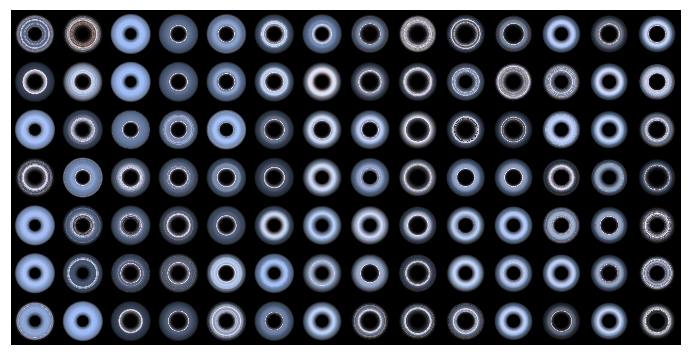

In [11]:
# radial plot of grids for a particular day
import gc
gc.collect()

def getcolor(cmap, frac):
    """ go fraction into cmap and return a color triple """
    l, w = cmap.shape
    assert(w ==3)
    i = int(l*frac)
    if i >= l:
        i = l-1
    if i < 0:
        i = 0
    return cmap[i,:]
    

def mapr(r):
    """map radius into a fraction of a colormap, 0 < r < .707"""
    return(2*r)

# width and height of inner frames


l, c = decd[0].shape

width = l
height = l

# with and height of grid, each grid element is a day
gwidth = 14
gheight = 7

out = np.zeros((gheight*height,gwidth*width,3),dtype=float)
dc = 2 
for gw in range(gwidth):
    for gh in range(gheight):
    
        for w in range(width):
            for h in range(height):

                x = (w - width/2)/float(width) 
                y = (h - height/2)/float(height)
                r = np.sqrt(x*x + y*y)
                #th = np.arctan2(y,x)
                #day = int(100*th*4/2*np.pi)
                # want to show morning, so outside (max) is zero and inside (min) is 1/2
                #print r
                #out[(gh*height) + h, (gw*width) + w] = getcolor(daysg[dc,:,:],mapr(r))
                out[(gh*height) + h, (gw*width) + w] = getcolor(decd[dc,:,:],mapr(r))
        dc += 1
        print gw, gh, dc
    
fname  = "griddo-wide.png"
imageio.imwrite(fname, (255*out).astype(np.uint8))
print "saved " + fname
fig = plt.figure(frameon=False, figsize = (12,12))
plt.imshow(out)
plt.axis('off')  
fig.axes[0].get_xaxis().set_visible(False)
fig.axes[0].get_yaxis().set_visible(False)
        #plt.savefig('advance{:03d}.png'.format(i),bbox_inches='tight', pad_inches=0)
print "saved"
    # to convert to gif with imagemagick
    #$ /cygdrive/c/Program\ Files/ImageMagick-7.0.5-Q16/convert.exe   -delay 7 -loop 0 frame*.png ani.gif
#ffmpeg -r 15 -f image2  -i frame%03d.png -vcodec libx264 -crf 25 -pix_fmt yuv420p  test.mp4


0 0 101
saved day20.png
saved


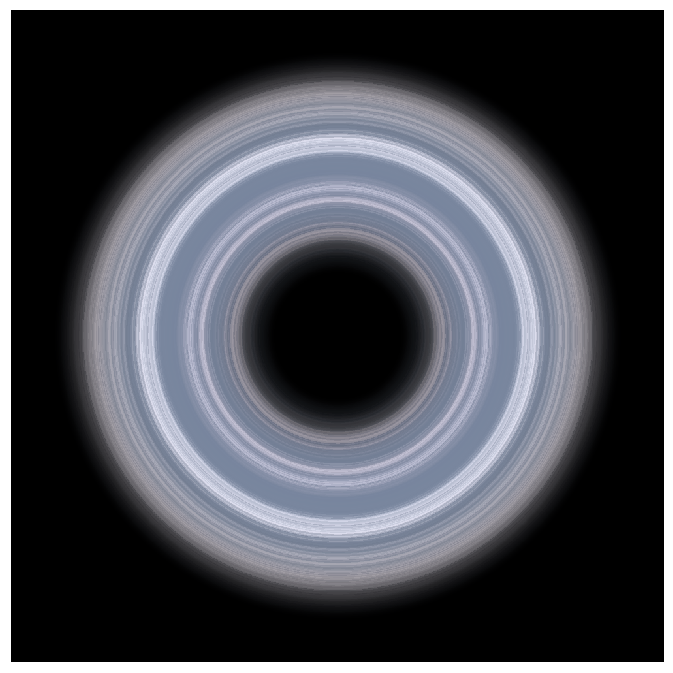

In [12]:
# radial plot of grids for a particular day
import gc
gc.collect()
def getcolor(cmap, frac):
    """ go fraction into cmap and return a color triple """
    l, w = cmap.shape
    assert(w ==3)
    i = int(l*frac)
    if i >= l:
        i = l-1
    if i < 0:
        i = 0
    return cmap[i,:]
    

def mapr(r):
    """map radius into a fraction of a colormap, 0 < r < .707"""
    return(2*r)

# width and height of inner frames
day = 20
froot = "day{}".format(day)
l, c = daysg[20].shape
width = 1000
height = 1000

# with and height of grid, each grid element is a day
gwidth = 1
gheight = 1

out = np.zeros((gheight*height,gwidth*width,3),dtype=float)
for gw in range(gwidth):
    for gh in range(gheight):
    
        for w in range(width):
            for h in range(height):

                x = (w - width/2)/float(width) 
                y = (h - height/2)/float(height)
                r = np.sqrt(x*x + y*y)
                #th = np.arctan2(y,x)
                #day = int(100*th*4/2*np.pi)
                # want to show morning, so outside (max) is zero and inside (min) is 1/2
                #print r
                out[(gh*height) + h, (gw*width) + w] = getcolor(daysg[day,:,:],mapr(r))
                #out[(gh*height) + h, (gw*width) + w] = getcolor(decd[dc,:,:],mapr(r))
        dc += 1
        print gw, gh, dc
    
fname  = froot + ".png"
imageio.imwrite(fname, (255*out).astype(np.uint8))
print "saved " + fname
fig = plt.figure(frameon=False, figsize = (12,12))
plt.imshow(out)
plt.axis('off')  
fig.axes[0].get_xaxis().set_visible(False)
fig.axes[0].get_yaxis().set_visible(False)
        #plt.savefig('advance{:03d}.png'.format(i),bbox_inches='tight', pad_inches=0)

write_hdr(out, froot + ".hdr")
print "saved"
    # to convert to gif with imagemagick
    #$ /cygdrive/c/Program\ Files/ImageMagick-7.0.5-Q16/convert.exe   -delay 7 -loop 0 frame*.png ani.gif
#ffmpeg -r 15 -f image2  -i frame%03d.png -vcodec libx264 -crf 25 -pix_fmt yuv420p  test.mp4


saved frame000.png
saved
saved frame001.png
saved frame002.png
saved frame003.png
saved frame004.png
saved frame005.png
saved frame006.png
saved frame007.png
saved frame008.png
saved frame009.png
saved frame010.png
saved frame011.png
saved frame012.png
saved frame013.png
saved frame014.png
saved frame015.png
saved frame016.png
saved frame017.png
saved frame018.png
saved frame019.png
saved frame020.png
saved frame021.png
saved frame022.png
saved frame023.png
saved frame024.png
saved frame025.png
saved frame026.png
saved frame027.png
saved frame028.png
saved frame029.png
saved frame030.png
saved frame031.png
saved frame032.png
saved frame033.png
saved frame034.png
saved frame035.png
saved frame036.png
saved frame037.png
saved frame038.png
saved frame039.png
saved frame040.png
saved frame041.png
saved frame042.png
saved frame043.png
saved frame044.png
saved frame045.png
saved frame046.png
saved frame047.png
saved frame048.png
saved frame049.png
saved frame050.png
saved frame051.png
saved 

saved frame431.png
saved frame432.png
saved frame433.png
saved frame434.png
saved frame435.png
saved frame436.png
saved frame437.png
saved frame438.png
saved frame439.png
saved frame440.png
saved frame441.png
saved frame442.png
saved frame443.png
saved frame444.png
saved frame445.png
saved frame446.png
saved frame447.png
saved frame448.png
saved frame449.png
saved frame450.png
saved frame451.png
saved frame452.png
saved frame453.png
saved frame454.png
saved frame455.png
saved frame456.png
saved frame457.png
saved frame458.png
saved frame459.png
saved frame460.png
saved frame461.png
saved frame462.png
saved frame463.png
saved frame464.png
saved frame465.png
saved frame466.png
saved frame467.png
saved frame468.png
saved frame469.png
saved frame470.png
saved frame471.png
saved frame472.png
saved frame473.png
saved frame474.png
saved frame475.png
saved frame476.png
saved frame477.png
saved frame478.png
saved frame479.png
saved frame480.png
saved frame481.png
saved frame482.png
saved frame4

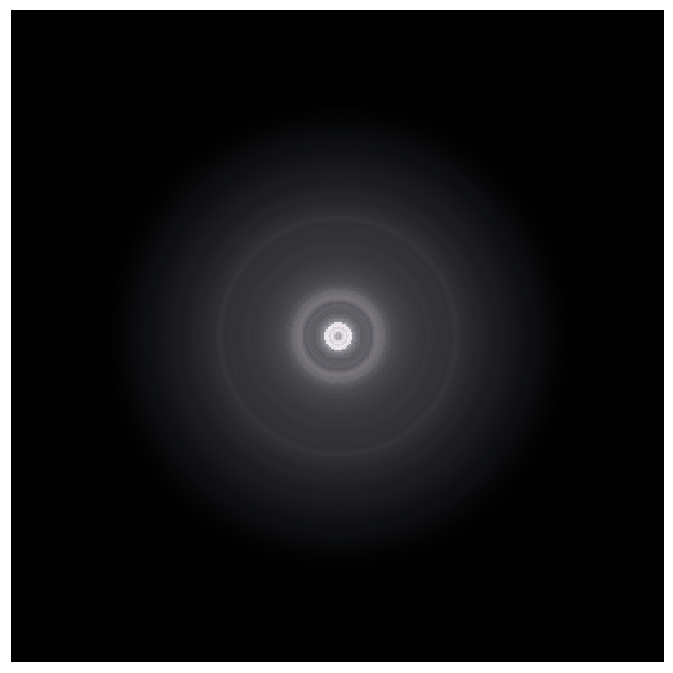

In [14]:
# radial plot

def getcolor(cmap, frac):
    """ go fraction into cmap and return a color triple """
    l, w = cmap.shape
    assert(w ==3)
    i = int(l*frac)
    if i >= l:
        i = l-1
    if i < 0:
        i = 0
    return cmap[i,:]
    

width = 400
height = 400
out = np.zeros((width,height,3),dtype=float)

offset = np.arange(-0.1,1.0, 0.002)
#offset =[0.]
for i, off in enumerate(offset):
    for w in range(width):
        for h in range(height):

            x = (w - width/2)/float(width) 
            y = (h - height/2)/float(height)
            r = np.sqrt(x*x + y*y)
            #th = np.arctan2(y,x)
            #day = int(100*th*4/2*np.pi)
            # want to show morning, so outside (max) is zero and inside (min) is 1/2
            out[h,w] = getcolor(daysg[1200],0.5*(1 + off -r))
        
        
    
    fname  = "frame{:03d}.png".format(i)
    imageio.imwrite(fname, (255*out).astype(np.uint8))
    print "saved " + fname
    if i ==0 :
        fig = plt.figure(frameon=False, figsize = (12,12))
        plt.imshow(out)
        plt.axis('off')  
        fig.axes[0].get_xaxis().set_visible(False)
        fig.axes[0].get_yaxis().set_visible(False)
        #plt.savefig('advance{:03d}.png'.format(i),bbox_inches='tight', pad_inches=0)
        print "saved"
    # to convert to gif with imagemagick
    #$ /cygdrive/c/Program\ Files/ImageMagick-7.0.5-Q16/convert.exe   -delay 7 -loop 0 frame*.png ani.gif
#ffmpeg -r 15 -f image2  -i frame%03d.png -vcodec libx264 -crf 25 -pix_fmt yuv420p  test.mp4


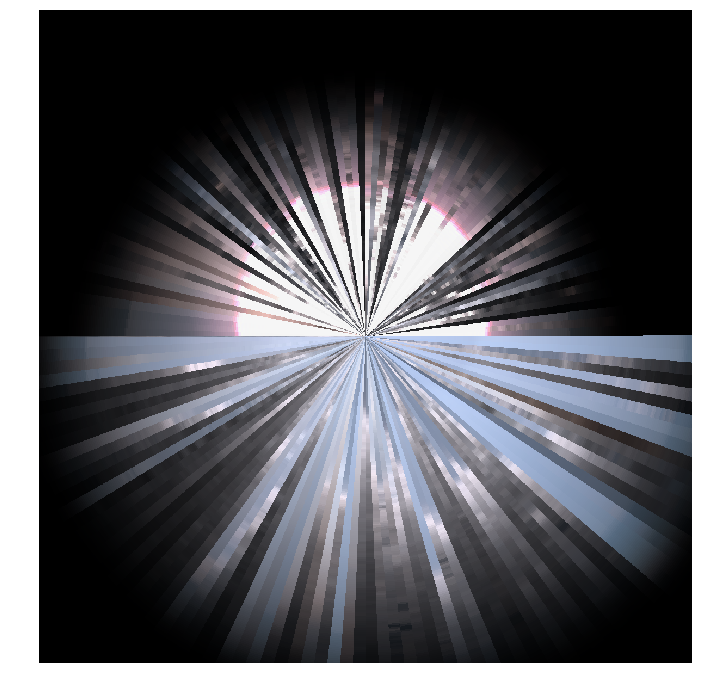

In [15]:
# radial plots

def getcolor(cmap, frac):
    """ go fraction into cmap and return a color triple """
    l, w = cmap.shape
    assert(w ==3)
    i = int(l*frac)
    if i >= l:
        i = l-1
    if i < 0:
        i = 0
    return cmap[i,:]
    

width = 1200
height = 1200
out = np.zeros((width,height,3),dtype=float)

for w in range(width):
    for h in range(height):

        x = (w - width/2)/float(width) 
        y = (h - height/2)/float(height)
        r = np.sqrt(x*x + y*y)
        th = np.arctan2(y,x)
        #print x, y, r
        #out[w,h,:] = [0, 0, 0]
        day = int(200*th*8/(2*np.pi))
        # want to show morning, so outside (max) is zero and inside (min) is 1/2
        out[h,w] = getcolor(daysg[day],0.5*(1-r))
        # want to show evening, so outside (max) is 1 and inside (min) is 1/2
        #out[h,w] = getcolor(days[200],1.2*(r + 1)/2)
        #out[h,w] = getcolor(days[200],r)
        
        
    

plt.figure(figsize = (12,12))
plt.imshow(out)
plt.axis('off')    
plt.savefig('radial4.png')

In [16]:
# spiral plots
from PIL import Image, ImageDraw
im = Image.new('RGBA', (400, 400), (0, 255, 0, 0)) 
draw = ImageDraw.Draw(im) 
draw.line((100,200, 150,300), fill=128)
im.show()

def getcolor(cmap, frac):
    """ go fraction into cmap and return a color triple """
    l, w = cmap.shape
    assert(w ==3)
    i = int(l*frac)
    if i >= l:
        i = l-1
    if i < 0:
        i = 0
    return cmap[i,:]
    


In [17]:
img.save('radialdays.png')

NameError: name 'img' is not defined

In [ ]:
def get_colors_for(c):
    red = c[:,1]
    grn = c[:,2]
    blu = c[:,3]

    mmax = np.max([np.max(red), np.max(blu), np.max(grn)])

    red = red/mmax
    grn = grn/mmax
    blu = blu/mmax


    colors = []
    for i, r in enumerate(red):
        colors.append(mpl.colors.to_rgb((red[i],grn[i],blu[i])))
    return colors

c = get_colors_for(newdata[0])


In [ ]:
newd = np.array(newd)
print newd.shape

In [ ]:
# make rectangular jpeg to wrap a sphere
import scipy.signal
from PIL import Image, ImageDraw

cmap = []
for d in newd[3:4]:
    print d.shape
    colors = d[:,1:4]
    # gamma correct
    colors = (colors / 65535.)**(1/2.2)
    colors = colors/np.max(colors)
    #colors = colors/mmax
    
    print colors.shape
    dcol =  scipy.signal.decimate(colors, 10, n=None, ftype='iir', axis=0, zero_phase=True)
    dcol_wide = np.multiply.outer(np.ones((1000)),dcol)
    cmap.extend(dcol_wide)
    
#dcol_wide = np.multiply.outer(np.ones((500)),dcol)
#dcol_wide = np.swapaxes(dcol_wide,1,2)
cmap = np.swapaxes(cmap,0,1)
cmap = np.array(cmap,dtype=float)
#print days.shape

#daysn = days/np.max(days)

#plt.imshow(cmap[1500:7500,:])
fig = plt.figure(frameon=False, figsize = (12,12))
plt.imshow(cmap[1500:7500,:])
plt.axis('off')  
fig.axes[0].get_xaxis().set_visible(False)
fig.axes[0].get_yaxis().set_visible(False)
plt.savefig('cmap.jpg',bbox_inches='tight', pad_inches=0)

In [ ]:
   fig = plt.figure(frameon=False, figsize = (12,12))
    plt.imshow(out)
    plt.axis('off')  
    fig.axes[0].get_xaxis().set_visible(False)
    fig.axes[0].get_yaxis().set_visible(False)
    plt.savefig('advance{:03d}.png'.format(i),bbox_inches='tight', pad_inches=0)